# Autoencoder Analysis for CNN Version
As noted in the workbook using the convolutional neural network version of the autoencoder, training takes a **long** time.   So this notebook will be used to analyze the output of the trained AE.   You can use this for both the short version you train in the jupyter notebook, as well as the version you train using straight python.

This method of saving data to files - especially for the longer jobs you might run - and then analyzing them in a jupyter notebook, can be helpful for some of the work you might do for your projects.

## Load the models and output pickle file
Note that we call the history object we load from pickle "history_history", not histroy.history.

In [2]:
from keras.models import load_model
import pickle

short = False
if short:
    encoder = load_model('fully_trained_encoder_cnn_small.h5')
    decoder = load_model('fully_trained_decoder_cnn_small.h5')
    autoencoder = load_model('fully_trained_autoencoder_cnn_small.h5')
    history_history = pickle.load(open('history_cnn_small.pkl', 'rb')) 
else:
    encoder = load_model('fully_trained_encoder_cnn.h5')
    decoder = load_model('fully_trained_decoder_cnn.h5')
    autoencoder = load_model('fully_trained_autoencoder_cnn.h5')
    history_history = pickle.load(open('history_cnn.pkl', 'rb')) 

print("history",history_history)

/users/PAS1585/sanchezrosales1/.local/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


history {'val_loss': [0.17734009201968587, 0.1612854792727691, 0.15385915709991285, 0.14978120788834595, 0.14813470699001385, 0.14472994165730257, 0.14410323504152833, 0.14334188114111132, 0.14639484303525488, 0.1411704460680001], 'val_mean_squared_error': [0.023958850157551004, 0.017938693853036577, 0.01535081410120432, 0.01399082807710362, 0.013433308637928637, 0.012540986404892413, 0.012296683412344843, 0.012001450773116415, 0.012811582730523772, 0.011339580796816191], 'loss': [0.2112638612306809, 0.1682161033160444, 0.15766696259140778, 0.1517435595409376, 0.14862226651831423, 0.14655575482216188, 0.14535280563164965, 0.14420764351604742, 0.14302215275134172, 0.1421001815899721], 'mean_squared_error': [0.03580197732308426, 0.02064138753858302, 0.016872219757896018, 0.01482073481128261, 0.013751343060003324, 0.013045044566655421, 0.012629133618493856, 0.012239534179978515, 0.011840794506425598, 0.011531170594219459]}


## Load the data
We will want to run on the data for some of the performance tests, particularly the test data.  Note that we don't load into a pandas datframe the **training** data: pandas dataframes can be **huge** and to save memory we won't load the training data (since we won't do anything with it in this workbook).

In [3]:
from keras.datasets import mnist
import numpy as np
import scipy.io as sio
#
# See this for more info: https://arxiv.org/pdf/1702.05373.pdf
mat = sio.loadmat('/fs/scratch/PAS1585/emnist/matlab/emnist-byclass.mat')
#print(mat)

data = mat['dataset']

ex_train = data['train'][0,0]['images'][0,0]
ey_train = data['train'][0,0]['labels'][0,0]
ex_test = data['test'][0,0]['images'][0,0]
ey_test = data['test'][0,0]['labels'][0,0]

ex_train = ex_train.reshape( (ex_train.shape[0], 28,28), order='F')
ex_test = ex_test.reshape( (ex_test.shape[0], 28,28), order='F')

ex_train = ex_train.reshape( (ex_train.shape[0], 784))
ex_test = ex_test.reshape( (ex_test.shape[0], 784))
ex_train = ex_train.astype('float32') / 255.
ex_test = ex_test.astype('float32') / 255.


import pandas as pd

#df_train = pd.DataFrame(ex_train)
#df_train['label'] = ey_train
#df_digits_train = df_train[df_train['label']<=9]
#x_train = df_digits_train.iloc[:50000,:784].values
#x_train = x_train.reshape((x_train.shape[0],28,28,1))
#y_train = df_digits_train.loc[:50000,'label'].values

df_test = pd.DataFrame(ex_test)
df_test['label'] = ey_test
df_digits_test = df_test[df_test['label']<=9]
x_test = df_digits_test.iloc[:,:784].values
x_test = x_test.reshape((x_test.shape[0],28,28,1))
y_test = df_digits_test['label'].values

#
from keras.utils import to_categorical

#y_train_labels_cat = to_categorical(y_train)
y_test_labels_cat = to_categorical(y_test)


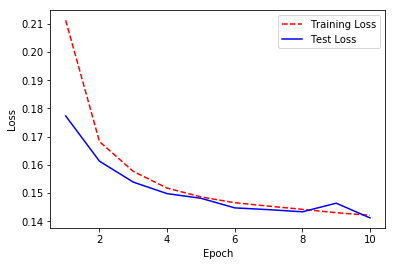

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

# Get training and test loss histories
training_loss = history_history['loss']
test_loss = history_history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

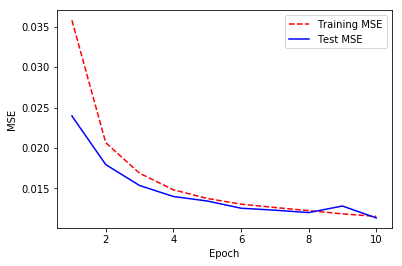

In [5]:
# Get training and test loss histories
training_loss = history_history['mean_squared_error']
test_loss = history_history['val_mean_squared_error']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training MSE', 'Test MSE'])
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show();

## Performance, Part II
Next we can try the "eye test": do the images at output look close to the images at input?

To test this, we first run all of our test images through the **predict** function of our network:

In [6]:
decoded_imgs = autoencoder.predict(x_test)
print("decoded_imgs.shape",decoded_imgs.shape)

decoded_imgs.shape (57918, 28, 28, 1)


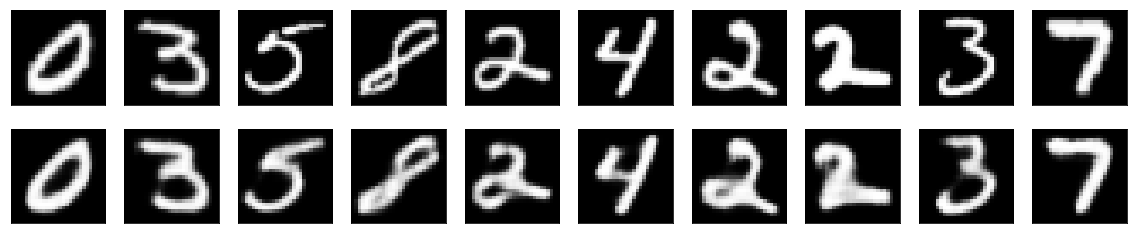

In [7]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Visualizing the filters of a CNN
One thing we have not yet focused on is exactly what our networks are learning.   Clearly the encoder is finding some structure in the digits, and the decoder can then take the structure and recreate at least somewhat the original digits.  

If we use the **summary** method of a keras model, we can inspect the structure a bit.  Let's do that for the encoder.

When we do this, we will see the output below.  Focusing on just the enocder convolutional layers we see that:
1.  The first convolutional layer has 16 filters (the last dimension in the Output Shape column)
2.  The second convolutional layer has 8 filters 
3.  The third convolutional layer has 8 filters 


In [8]:
print(encoder.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0         
Total params: 1,904
Trainable params: 1,904
Non-trainable params: 0
_________________________________________________________________
None


## Visualizing the filters of a CNN (continued)
To understand what these filters are doing, we will use a method from Chapter 5 of the Deep Learning with Python text.   The idea is to find an image (starting from a randomly initialized image) which causes each of the filters to respond maximally.   In some sense, this is the stucture that the filter is "looking for" in the input images.

Here is the relevant code from Chapter 5:

In [9]:
import numpy as np
from keras import backend as K

def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
#    x *= 0.1
    x *= 0.3
    
    x+= 0.5
    x = np.clip(x,0,1)
    
    x*= 255
    x = np.clip(x,0,255).astype('uint8')
    return x

def generate_pattern(model,layer_name,filter_index,size=28):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    grads = K.gradients(loss,model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input],[loss,grads])
    input_img_data = np.random.random((1,size,size,1))*20+128.0

    step = 1.0
    for i in range(40):
        loss_value,grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    
    img = input_img_data[0]
    return deprocess_image(img)

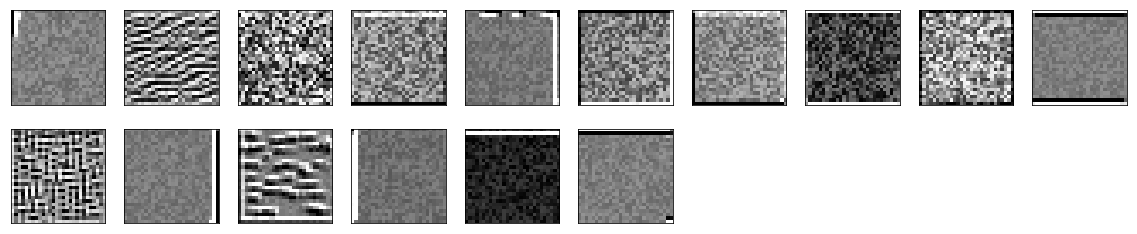

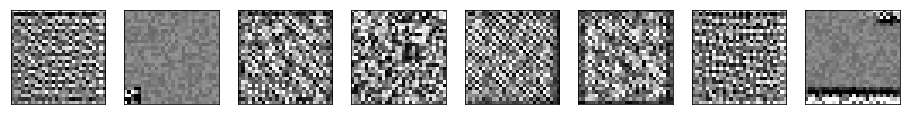

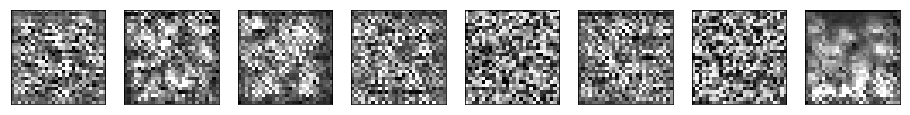

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 4))
for i in range(16):
    # display original
    ax = plt.subplot(2, n, i + 1)
    thisImg = generate_pattern(encoder,'conv2d_1',i)
    plt.imshow(thisImg.reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(20, 4))
for i in range(8):
    # display original
    ax = plt.subplot(2, n, i + 1)
    thisImg = generate_pattern(encoder,'conv2d_2',i)
    plt.imshow(thisImg.reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(20, 4))
for i in range(8):
    # display original
    ax = plt.subplot(2, n, i + 1)
    thisImg = generate_pattern(encoder,'conv2d_3',i)
    plt.imshow(thisImg.reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
